In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [ ]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_fixed")
features = ["game_completed", "relative_strength", "score_difference", "type.id", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML


In [31]:
# Reset the modules
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

import process_data

training_data = process_data.load_data(interpolated_dir, 
                                       years = [2016, 2017,2018, 2019, 2020, 2021, 2022], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

validation_data = process_data.load_data(interpolated_dir, 
                                       years = [2023], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = True
                                       )
                                       
test_data = process_data.load_data(interpolated_dir, 
                                       years = [2024],
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = False
                                       )

Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2017/game_400951752.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2017/game_400951752.csv
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2019/game_401127989.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2019/game_401127963.csv
  NaN foun

In [4]:
# Get information about the data
for timestep in training_data:
    print(f"timestep: {timestep}, number of instances: {len(training_data[timestep])}")

timestep: 0.0, number of instances: 3244
timestep: 0.005, number of instances: 1142
timestep: 0.01, number of instances: 2157
timestep: 0.015, number of instances: 1805
timestep: 0.02, number of instances: 2016
timestep: 0.025, number of instances: 2086
timestep: 0.03, number of instances: 1976
timestep: 0.035, number of instances: 2157
timestep: 0.04, number of instances: 2047
timestep: 0.045, number of instances: 2177
timestep: 0.05, number of instances: 2126
timestep: 0.055, number of instances: 2038
timestep: 0.06, number of instances: 2220
timestep: 0.065, number of instances: 2157
timestep: 0.07, number of instances: 2181
timestep: 0.075, number of instances: 2135
timestep: 0.08, number of instances: 2193
timestep: 0.085, number of instances: 2211
timestep: 0.09, number of instances: 2122
timestep: 0.095, number of instances: 2207
timestep: 0.1, number of instances: 2178
timestep: 0.105, number of instances: 2161
timestep: 0.11, number of instances: 2234
timestep: 0.115, number o

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
# Define which features to scale vs. passthrough
numeric_features = [
    "homeScore", "awayScore", "start.down", "start.distance", "start.yardLine",
    "end.down", "end.distance", "end.yardLine",
]
other_features = ["relative_strength", "scoringPlay", "home_has_possession", "home_timeouts_left", "away_timeouts_left"] # for timestep in training_data.keys():


numeric_feature_indices = [
    0,  # score_difference
    1,  # relative_strength  
    4,  # end.down
    5,  # end.yardsToEndzone
    6,  # end.distance
    7,  # field_position_shift
]

# Features that should NOT be scaled (categorical/binary/discrete)
other_feature_indices = [
    2,  # type.id (categorical)
    3,  # home_has_possession (binary)
    8,  # home_timeouts_left (discrete 0-3)
    9,  # away_timeouts_left (discrete 0-3)
]

print("Features to be scaled:", numeric_features)
print("Features to passthrough:", other_features)

# Scale the data pipeline (using column indices for numpy arrays)
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_feature_indices),
    ("passthrough", "passthrough", other_feature_indices)
])

# No scaling pipeline (for comparison)
preprocessor_no_scaling = ColumnTransformer(transformers=[
    ("passthrough", "passthrough", list(range(len(features))))
])
# TO DO:
# - Rounding for end games
# - Only keep home_has_possession + timeouts_left + everything I had before - DONE
# - Kernel based methods
#   - At least 10 data points to do an estimation
#   - Score difference - make it categorical

Features to be scaled: ['homeScore', 'awayScore', 'start.down', 'start.distance', 'start.yardLine', 'end.down', 'end.distance', 'end.yardLine']
Features to passthrough: ['relative_strength', 'scoringPlay', 'home_has_possession', 'home_timeouts_left', 'away_timeouts_left']


In [6]:
print(training_data[0.0][0]["rows"].shape)

(11,)


In [24]:
modules_to_reload = [
    'models.direct_prediction_network',
    'models.direct_prediction_network_transformer',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from models.direct_prediction_network import setup_direct_models
from models.direct_prediction_network_transformer import setup_direct_transformer_models


models = setup_direct_models(training_data, validation_data, num_models = 201, features=features, optimize_hyperparams=False)

Original data shape: (3244, 11)
Flattened data shape: (3244, 11)
Using provided test data as validation: 3244 train, 526 validation

Training direct prediction model for timestep range [0.0, 0.005]
Starting training on device: cpu
Early stopping at epoch 11
Best epoch: 1, Train Acc: 0.6174, Train Loss: 0.2313, Val Acc: 0.6312, Val Loss: 0.2261
Restored model from best epoch 1 with val_loss: 0.226104
NFL direct model 1/201 completed
Original data shape: (1142, 11)
Flattened data shape: (1142, 11)
Using provided test data as validation: 1142 train, 124 validation

Training direct prediction model for timestep range [0.005, 0.01]
Starting training on device: cpu
Early stopping at epoch 11
Best epoch: 1, Train Acc: 0.5508, Train Loss: 0.2445, Val Acc: 0.5806, Val Loss: 0.2349
Restored model from best epoch 1 with val_loss: 0.234942
NFL direct model 2/201 completed
Original data shape: (2157, 11)
Flattened data shape: (2157, 11)
Using provided test data as validation: 2157 train, 327 valida

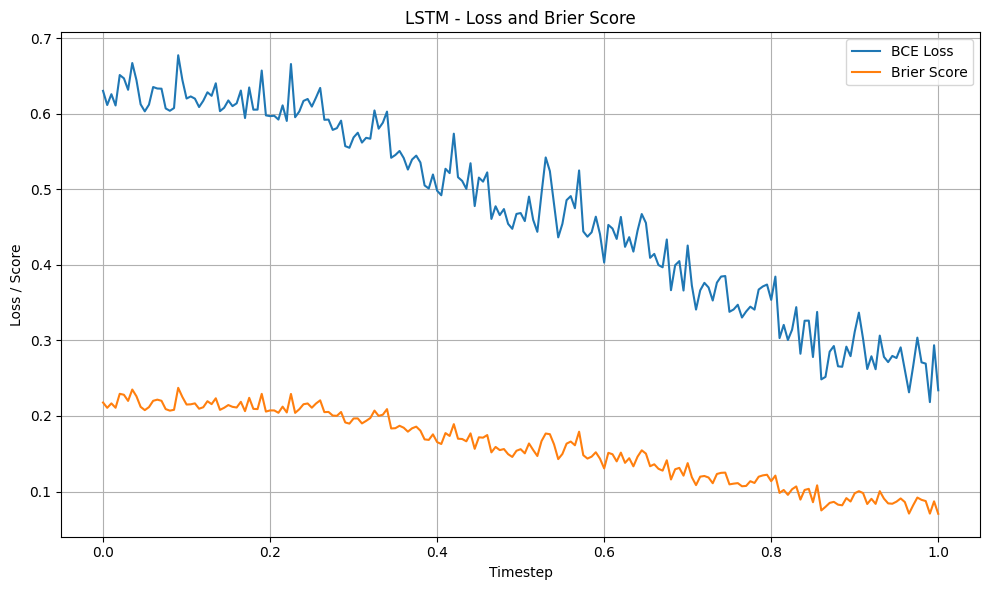

In [25]:
import process_data
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

x = process_data.plot_loss(models, test_data, "LSTM")

Timestep 0.00%: Test Accuracy = 0.7055
Timestep 0.50%: Test Accuracy = 0.6854
Timestep 1.00%: Test Accuracy = 0.6810
Timestep 1.50%: Test Accuracy = 0.6891
Timestep 2.00%: Test Accuracy = 0.6455
Timestep 2.50%: Test Accuracy = 0.6632
Timestep 3.00%: Test Accuracy = 0.6603
Timestep 3.50%: Test Accuracy = 0.6505
Timestep 4.00%: Test Accuracy = 0.6513
Timestep 4.50%: Test Accuracy = 0.6767
Timestep 5.00%: Test Accuracy = 0.7030
Timestep 5.50%: Test Accuracy = 0.6707
Timestep 6.00%: Test Accuracy = 0.7017
Timestep 6.50%: Test Accuracy = 0.6574
Timestep 7.00%: Test Accuracy = 0.6427
Timestep 7.50%: Test Accuracy = 0.6660
Timestep 8.00%: Test Accuracy = 0.7044
Timestep 8.50%: Test Accuracy = 0.7048
Timestep 9.00%: Test Accuracy = 0.6264
Timestep 9.50%: Test Accuracy = 0.6853
Timestep 10.00%: Test Accuracy = 0.6541
Timestep 10.50%: Test Accuracy = 0.6814
Timestep 11.00%: Test Accuracy = 0.6478
Timestep 11.50%: Test Accuracy = 0.6550
Timestep 12.00%: Test Accuracy = 0.6868
Timestep 12.50%: Tes

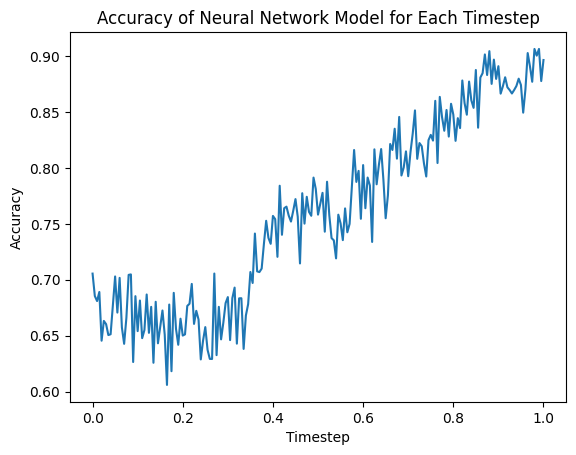

In [8]:
# Test accuracy of model for each timestep on test data and plot
accuracies = []
timesteps = []
for timestep in test_data.keys():
    model = models[timestep]
    # Convert test data to array
    y_test = np.array([row["label"] for row in test_data[timestep]])
    X_test = np.array([row["rows"].reshape(-1) for row in test_data[timestep]])
    # Evaluate model using the pipeline (preprocessing + logistic regression)
    test_accuracy = model.score(X_test, y_test)
    print(f"Timestep {timestep:.2%}: Test Accuracy = {test_accuracy:.4f}")
    accuracies.append(test_accuracy)
    timesteps.append(timestep)

plt.plot(timesteps, accuracies)
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.title("Accuracy of Neural Network Model for Each Timestep")
plt.show()

In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
%reload_ext autoreload

PermutationExplainer explainer: 365it [00:13,  6.95it/s]                         


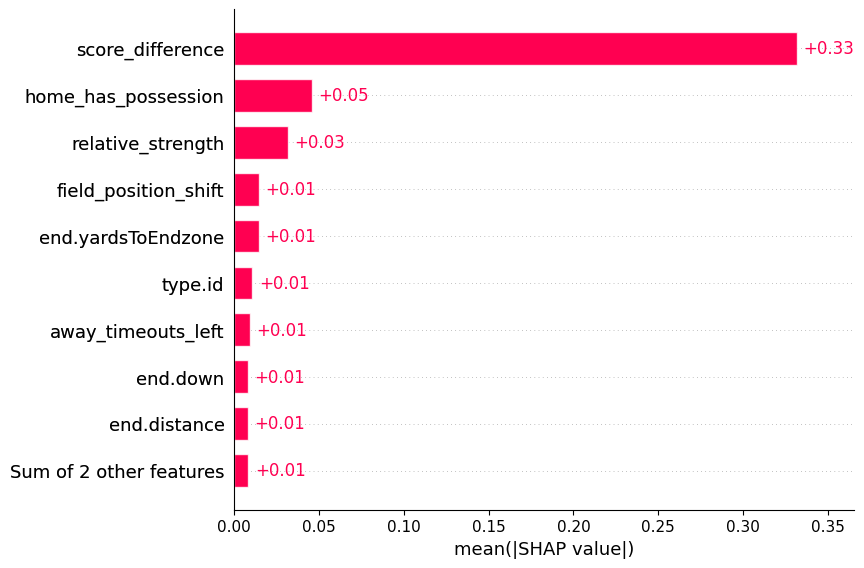

.values =
array([[-5.22444304e-01, -1.75063103e-03,  3.57689166e-03, ...,
        -8.23456611e-03,  1.70319158e-03,  2.02856011e-03],
       [-5.26710978e-01, -9.79733649e-04,  1.93670555e-03, ...,
        -3.83939714e-03,  9.37581235e-04,  1.58019682e-03],
       [-4.83338309e-01, -8.45959098e-04, -3.30062502e-04, ...,
        -8.01757826e-03, -9.87743796e-04,  2.55215049e-03],
       ...,
       [ 2.53334097e-01, -5.68626230e-03, -2.58235223e-02, ...,
        -2.59786324e-02, -3.19025597e-03, -5.29306458e-02],
       [ 2.77540613e-01,  2.48721609e-04, -1.46657779e-02, ...,
        -3.31360355e-02, -1.49815454e-02,  2.71557215e-03],
       [ 2.03108740e-01, -9.69217704e-04,  1.02640502e-02, ...,
        -9.90007754e-04,  4.29256542e-04,  5.13956415e-03]])

.base_values =
array([0.54075061, 0.54075061, 0.54075061, 0.54075061, 0.54075061,
       0.54075061, 0.54075061, 0.54075061, 0.54075061, 0.54075061,
       0.54075061, 0.54075061, 0.54075061, 0.54075061, 0.54075061,
       0.5407506

In [28]:
modules_to_reload = [
    'models.direct_prediction_network',
    'models.direct_prediction_network_transformer',
    'models.utils'
]
from models.utils import SHAP_analysis

SHAP_analysis(models, 0.9, training_data, test_data)

In [24]:
from process_data import write_predictions
from sklearn.preprocessing import StandardScaler
# Reload the modules
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]


write_predictions(models, interpolated_dir, [2024], 0, features, replace_nan_val = 0, phat_b = "NN_phat_b_model")


Loading data for 2024
Processed file:  game_401671629.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671628.csv
Processed file:  game_401671616.csv
Processed file:  game_401671831.csv
Processed file:  game_401671825.csv
Processed file:  game_401671819.csv
Processed file:  game_401671762.csv
Processed file:  game_401671776.csv
Processed file:  game_401671789.csv
Processed file:  game_401671788.csv
Processed file:  game_401671777.csv
Processed file:  game_401671763.csv
Processed file:  game_401671818.csv
Processed file:  game_401671824.csv
Processed file:  game_401671830.csv
Proces